## 掛載雲端硬碟


In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [3]:
# 本地執行，工作目錄已經在正確位置
import os
os.chdir('/home/twccjq88/2025EAI_Project/EAI_Lab2')

## Import library

In [4]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

from models.resnet import ResNet50


## 設定超參數

In [5]:
SEED = 1
TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1000
EPOCHS = 40
LEARNING_RATE = 1e-3
LOG_INTERVAL = 100
CUDA = True

RESUME = True
START_EPOCH = 0

# 路徑設定
PRUNE_PATH = '/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_prune.pth'
PRUNE_FINETUNE_PATH = '/home/twccjq88/2025EAI_Project/EAI_Lab2/checkpoints/model_prune_finetune.pth'


#### 檢查是否檢查是否可使用GPU

In [6]:
if torch.cuda.is_available():
    CUDA = True
    cuda_count = torch.cuda.device_count()
    device_names = [torch.cuda.get_device_name(i) for i in range(cuda_count)]
    print(f"Detected {cuda_count} CUDA device(s): {device_names}")
    device = torch.device('cuda')
    kwargs = {'num_workers': 8, 'pin_memory': True, 'prefetch_factor': 4}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    cuda_count = 0
    device = torch.device('cpu')
    kwargs = {}
    print("CUDA not available, using CPU.")


Detected 2 CUDA device(s): ['Tesla V100-SXM2-32GB', 'Tesla V100-SXM2-32GB']


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [7]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 載入剪枝後的網路與權重

In [8]:
# 載入剪枝後的模型
if RESUME:
    checkpoint = torch.load(PRUNE_PATH, map_location=device)
    cfg = checkpoint['cfg']
    model = ResNet50(num_classes=10, cfg=cfg)
    model.load_state_dict(checkpoint['state_dict'])
    print('Pruned model loaded')
else:
    model = ResNet50(num_classes=10)
    print('Training from scratch')

# 多GPU支援
if CUDA:
    model = model.cuda()
    if torch.cuda.device_count() > 1:
        print(f"Training using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    else:
        print("Training using a single GPU")

Pruned model loaded
Training using 2 GPUs


/tmp/ipykernel_38752/2879581351.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRUNE_PATH, map_location=device)


## 設定 Optimizer & CrossEntropy Loss

In [9]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## 定義訓練跟測試函數

In [10]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!

def train(epoch):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Forward and backward pass
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=False):
            output = model(data.float())
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        train_loss += loss.item() * data.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        total += target.size(0)

    # Calculate metrics
    train_acc = correct.item() / float(total)
    avg_loss = train_loss / total
    return train_acc, avg_loss


#### 測試函數 ####
def test():
    """Evaluate on test set"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            with torch.cuda.amp.autocast(enabled=False):
                output = model(data.float())
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            total += target.size(0)

    # Calculate metrics
    test_acc = correct.item() / float(total)
    avg_loss = test_loss / total
    return test_acc, avg_loss


# ==================== Fine-tuning Loop ====================
print("="*70)
print("🔧 Starting Fine-tuning on Pruned Model")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print("="*70)

# 記錄訓練歷史 (for plotting)
train_acc_history = []
train_loss_history = []
test_acc_history = []
test_loss_history = []

best_test_acc = 0.0

for epoch in range(START_EPOCH, EPOCHS):
    # Learning rate schedule
    if epoch in [int(EPOCHS*0.5), int(EPOCHS*0.75)]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f"📉 Learning rate reduced to {param_group['lr']}")
    
    # Train and evaluate
    train_acc, train_loss = train(epoch)
    test_acc, test_loss = test()
    
    # Record history
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    
    # Print summary (簡潔單行格式)
    print(f"Epoch {epoch:2d}/{EPOCHS} | "
          f"Train: Loss={train_loss:.4f} Acc={train_acc*100:.2f}% | "
          f"Test: Loss={test_loss:.4f} Acc={test_acc*100:.2f}% | "
          f"{'✓ Best!' if test_acc > best_test_acc else ''}")

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_test_acc': best_test_acc,
            'optimizer': optimizer.state_dict(),
            'cfg': cfg,
            'train_acc_history': train_acc_history,
            'test_acc_history': test_acc_history,
        }, PRUNE_FINETUNE_PATH)

print("\n" + "="*70)
print(f"✅ Fine-tuning Complete!")
print(f"   Best Test Accuracy: {best_test_acc*100:.2f}%")
print(f"   Model saved to: {PRUNE_FINETUNE_PATH}")
print("="*70)


🔧 Starting Fine-tuning on Pruned Model
   Epochs: 40
   Learning Rate: 0.001


/tmp/ipykernel_38752/3144343076.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/twccjq88/2025EAI_Project/EAI_Lab2/models/resnet.py:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/tmp/ipykernel_38752/3144343076.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Epoch  0/40 | Train: Loss=0.4546 Acc=84.62% | Test: Loss=0.4282 Acc=86.70% | ✓ Best!
Epoch  1/40 | Train: Loss=0.2773 Acc=90.41% | Test: Loss=0.4061 Acc=87.42% | ✓ Best!
Epoch  2/40 | Train: Loss=0.2496 Acc=91.26% | Test: Loss=0.4103 Acc=87.61% | ✓ Best!
Epoch  3/40 | Train: Loss=0.2315 Acc=91.96% | Test: Loss=0.4035 Acc=87.96% | ✓ Best!
Epoch  4/40 | Train: Loss=0.2205 Acc=92.25% | Test: Loss=0.4227 Acc=87.74% | 
Epoch  5/40 | Train: Loss=0.2015 Acc=92.88% | Test: Loss=0.4032 Acc=88.53% | ✓ Best!
Epoch  6/40 | Train: Loss=0.1969 Acc=93.16% | Test: Loss=0.3792 Acc=88.96% | ✓ Best!
Epoch  7/40 | Train: Loss=0.1844 Acc=93.55% | Test: Loss=0.4242 Acc=87.56% | 
Epoch  8/40 | Train: Loss=0.1830 Acc=93.56% | Test: Loss=0.4055 Acc=88.27% | 
Epoch  9/40 | Train: Loss=0.1666 Acc=94.08% | Test: Loss=0.4089 Acc=88.37% | 
Epoch 10/40 | Train: Loss=0.1613 Acc=94.26% | Test: Loss=0.4139 Acc=87.97% | 
Epoch 11/40 | Train: Loss=0.1634 Acc=94.25% | Test: Loss=0.4075 Acc=88.39% | 
Epoch 12/40 | Train: L

## 繪製Fine-tuning結果圖


/tmp/ipykernel_38752/604359719.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRUNE_FINETUNE_PATH, map_location='cpu')


Figure saved: finetuning_results.png


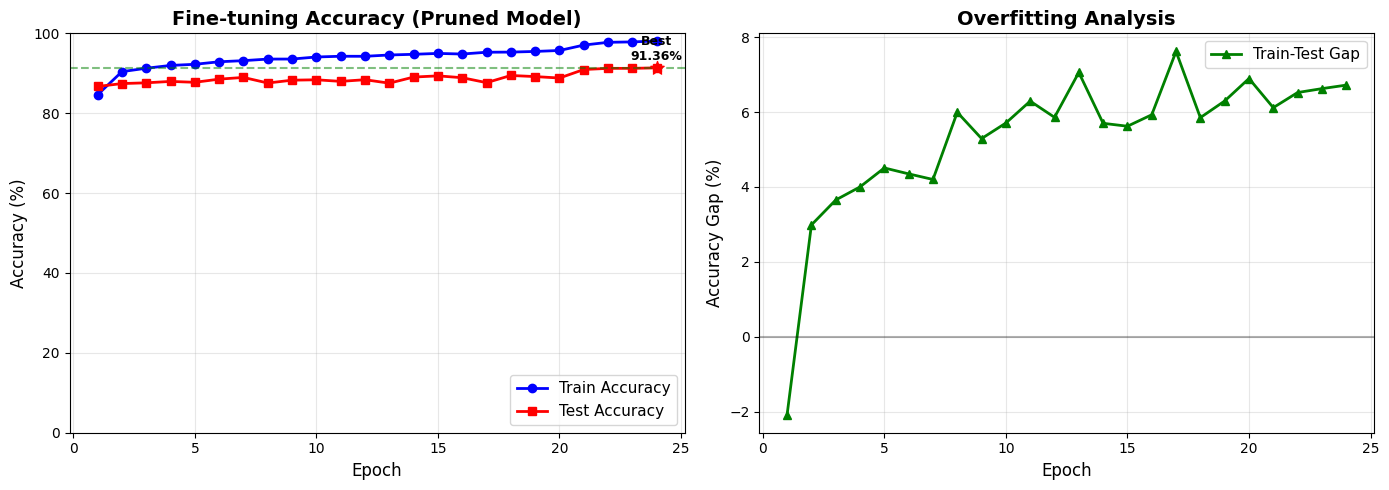


Fine-tuning statistics:
Total number of epochs: 24
Final training accuracy: 98.08%
Final test accuracy: 91.36%
Best test accuracy: 91.36% (Epoch 24)
Final overfitting gap: 6.72%
Average overfitting gap: 5.32%


In [14]:
# ==================== Plot Fine-tuning Results ====================

import matplotlib.pyplot as plt
import numpy as np

# Load the trained model to obtain history data
if os.path.exists(PRUNE_FINETUNE_PATH):
    checkpoint = torch.load(PRUNE_FINETUNE_PATH, map_location='cpu')
    train_acc_history = checkpoint.get('train_acc_history', [])
    test_acc_history = checkpoint.get('test_acc_history', [])
    
    epochs = range(1, len(train_acc_history) + 1)
    
    # Create figure
    plt.figure(figsize=(14, 5))
    
    # Subplot 1: Accuracy curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, [acc * 100 for acc in train_acc_history], 'b-o', label='Train Accuracy', linewidth=2, markersize=6)
    plt.plot(epochs, [acc * 100 for acc in test_acc_history], 'r-s', label='Test Accuracy', linewidth=2, markersize=6)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Fine-tuning Accuracy (Pruned Model)', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 100])
    
    # Mark the best test accuracy
    best_test_acc = max(test_acc_history)
    best_epoch = test_acc_history.index(best_test_acc) + 1
    plt.axhline(y=best_test_acc * 100, color='g', linestyle='--', alpha=0.5, label=f'Best: {best_test_acc*100:.2f}%')
    plt.scatter([best_epoch], [best_test_acc * 100], color='red', s=100, zorder=5, marker='*')
    plt.text(best_epoch, best_test_acc * 100 + 2, f'Best\n{best_test_acc*100:.2f}%', 
             ha='center', fontsize=9, fontweight='bold')
    
    # Subplot 2: Accuracy gap (overfitting degree)
    plt.subplot(1, 2, 2)
    gap = [(train - test) * 100 for train, test in zip(train_acc_history, test_acc_history)]
    plt.plot(epochs, gap, 'g-^', label='Train-Test Gap', linewidth=2, markersize=6)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy Gap (%)', fontsize=12)
    plt.title('Overfitting Analysis', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('finetuning_results.png', dpi=150, bbox_inches='tight')
    print("Figure saved: finetuning_results.png")
    plt.show()
    
    # Print statistics
    print("\n" + "="*70)
    print("Fine-tuning statistics:")
    print("="*70)
    print(f"Total number of epochs: {len(train_acc_history)}")
    print(f"Final training accuracy: {train_acc_history[-1]*100:.2f}%")
    print(f"Final test accuracy: {test_acc_history[-1]*100:.2f}%")
    print(f"Best test accuracy: {best_test_acc*100:.2f}% (Epoch {best_epoch})")
    print(f"Final overfitting gap: {gap[-1]:.2f}%")
    print(f"Average overfitting gap: {np.mean(gap):.2f}%")
    print("="*70)
    
else:
    print("Fine-tuning model file not found, please complete training first!")


## FLOPs & Parameters

In [12]:
!pip install thop
!pip install torchsummary

In [13]:
from thop import profile
from torchsummary import summary

##### 使用 thop 計算 FLOPs 和參數數量 #####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ← 修復: 先解包 DataParallel,再移到 device
if isinstance(model, torch.nn.DataParallel):
    model = model.module

model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
# summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 141799924.0
Params: 3973494.0
